In [1]:
import vice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [29]:
agb = pd.read_csv("c_isotope_fruitty.txt", sep="\s+")
agb["C12"] /= agb["Mass"]
agb["C13"] /= agb["Mass"]
df = agb
df = df[df["Metallicity"] > 0.00005]

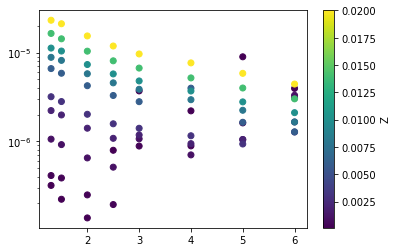

In [30]:
plt.scatter(df["Mass"], df["C13"]*df["Mass"]**-1.3, c=df["Metallicity"])
plt.colorbar(label="Z")
plt.yscale("log")

In [31]:


def set_isotope(col, ele):
    c12 = df.pivot("Mass", "Metallicity", col)
    M = c12.index.to_list()
    Z = c12.columns.to_list()
    vice.yields.agb.settings[ele] = vice.toolkit.interpolation.interp_scheme_2d(M, Z, c12.to_numpy())

set_isotope("C12", "au")
set_isotope("C13", "ag")

In [32]:
vice.yields.ccsne.settings["c"] = 0.00
vice.yields.sneia.settings["c"] = 0

vice.yields.ccsne.settings["au"] = 0.00
vice.yields.sneia.settings["au"] = 0

vice.yields.ccsne.settings["ag"] = 0
vice.yields.sneia.settings["ag"] = 0

In [33]:
vice.solar_z["au"]= vice.solar_z("c") * 86/87
vice.solar_z["ag"] = vice.solar_z("c")/87

Text(0, 0.5, 'y_c12_agb')

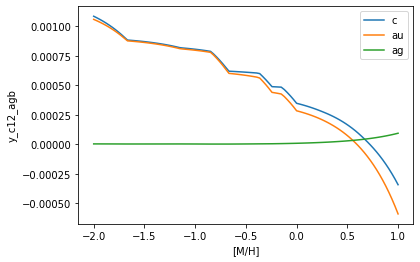

In [34]:
Zs = 0.014*10**np.linspace(-2, 1, 100)

def y_agb(ele):
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population(ele, Z=Z)
        mass_yields.append(m_c[-1])
    return np.array(mass_yields)/1e6
for ele in ["c", "au", "ag"]:
    plt.plot(np.log10(Zs/0.014), y_agb(ele), label=ele)

plt.legend()
plt.xlabel("[M/H]")
plt.ylabel("y_c12_agb")

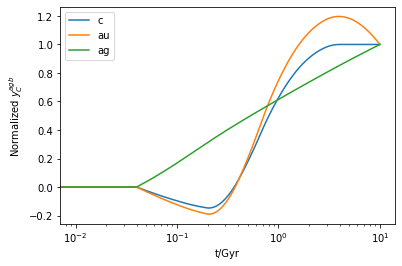

In [35]:
for ele in ["c", "au", "ag"]:
    m_c, times = vice.single_stellar_population(ele, Z=0.014)
    m_c = [c  for c in m_c]
    plt.plot(times, np.array(m_c)/m_c[-1], label=ele)
    
    
#vice.yields.agb.settings["c"] = yields.y_c_gauss()
#m_c, times = vice.single_stellar_population("c", Z=0.014)
#m_c = [c - 0.002*1e6 for c in m_c]
#plt.plot(times, np.array(m_c)/m_c[-1], label="analytic")

plt.xlabel("t/Gyr")
plt.ylabel("Normalized $y_C^{agb}$")
plt.xscale("log")
plt.legend()


In [36]:
y_agb_c12 = y_agb("au")
y_agb_c13 = y_agb("ag")

In [37]:
MoverH = np.log10(Zs/0.014)

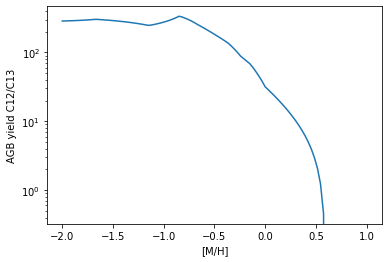

In [40]:
plt.plot(MoverH, y_agb_c12/y_agb_c13)
plt.xlabel("[M/H]")
plt.ylabel("AGB yield C12/C13")
plt.yscale("log")

# CCSNe

In [41]:
from scipy.integrate import quad

In [42]:
imf = vice.imf.kroupa
imf_norm = quad(lambda m: imf(m)*m, 0.08, 100)[0]
m_min = 8
m_max = 100

In [43]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

In [44]:
vrot = 0
yields_c12 = []
yields_c13 = []
study = "WW95"
MoverH = allowed_MoverH[study]
for M_H in MoverH:
    t = vice.yields.ccsne.table("c", study=study, isotopic=True, MoverH=M_H)
    
    f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c13"] for m in t.masses])
    y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
    yields_c13.append(y_c13_cc)
    
    f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c12"] for m in t.masses])
    y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
    yields_c12.append(y_c12_cc)

<ipython-input-44-456bcce7a67e>:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm


<ipython-input-45-61b4d720b833>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
<ipython-input-45-61b4d720b833>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm


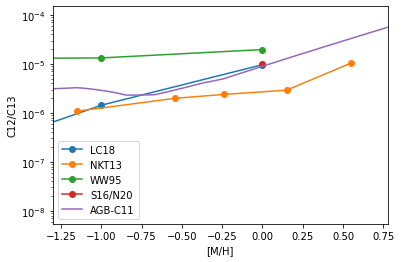

In [45]:
for study in ["LC18", "NKT13", "WW95", "S16/N20"]:
    vrot = 0
    yields_c12 = []
    yields_c13 = []

    MoverH = allowed_MoverH[study]
    for M_H in MoverH:
        t = vice.yields.ccsne.table("c", study=study, isotopic=True, MoverH=M_H)

        f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c13"] for m in t.masses])
        y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c13.append(y_c13_cc)

        f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c12"] for m in t.masses])
        y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c12.append(y_c12_cc)
        
    plt.plot(MoverH, yields_c13, marker="o", label=study)
plt.yscale("log")
plt.xlabel("[M/H]")
plt.ylabel("C12/C13")
plt.xlim(-1.3)

# plot agb
MoverH = np.linspace(-2, 1, 100)
plt.plot(MoverH,y_agb_c13, label="AGB-C11")


plt.legend()

<ipython-input-46-fb68e42a5895>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
<ipython-input-46-fb68e42a5895>:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm


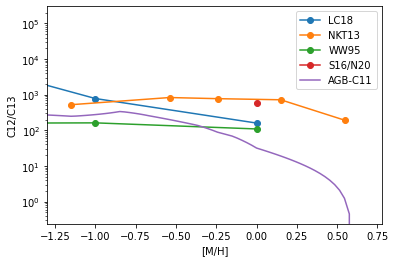

In [46]:
for study in ["LC18", "NKT13", "WW95", "S16/N20"]:
    vrot = 0
    yields_c12 = []
    yields_c13 = []

    MoverH = allowed_MoverH[study]
    for M_H in MoverH:
        t = vice.yields.ccsne.table("c", study=study, isotopic=True, MoverH=M_H)

        f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c13"] for m in t.masses])
        y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c13.append(y_c13_cc)

        f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m]["c12"] for m in t.masses])
        y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c12.append(y_c12_cc)
        
    plt.plot(MoverH, np.array(yields_c12)/yields_c13, marker="o", label=study)
plt.yscale("log")
plt.xlabel("[M/H]")
plt.ylabel("C12/C13")
plt.xlim(-1.3)

# plot agb
MoverH = np.linspace(-2, 1, 100)
plt.plot(MoverH, y_agb_c12/y_agb_c13, label="AGB-C11")


plt.legend()


In [47]:
def calc_cc_yields(study="LC18"):
    vrot = 0
    yields_c12 = []
    yields_c13 = []

    MoverH = allowed_MoverH[study]
    m_max=100
    
    for M_H in MoverH:
        t = vice.yields.ccsne.table("c", study=study, isotopic=True, MoverH=M_H)
        masses = [8] + list(t.masses)

        f = vice.toolkit.interpolation.interp_scheme_1d(masses, [0] + [t[m]["c13"] for m in t.masses])
        y_c13_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c13.append(y_c13_cc)

        f = vice.toolkit.interpolation.interp_scheme_1d(masses, [0] + [t[m]["c12"] for m in t.masses])
        y_c12_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
        yields_c12.append(y_c12_cc)
        
    return yields_c12, yields_c13

In [48]:
study = "LC18"
yields_c12, yields_c13 = calc_cc_yields(study)

In [49]:
vrot = 0
yields_c = []

MoverH = allowed_MoverH[study]
m_max=100
for M_H in MoverH:
    t = vice.yields.ccsne.table("c", study=study, isotopic=False, MoverH=M_H)
    masses = [8] + list(t.masses)
    y = [0] + [t[m] for m in t.masses]
    f = vice.toolkit.interpolation.interp_scheme_1d(t.masses, [t[m] for m in t.masses])
    y_c_cc = quad(lambda m: imf(m) * f(m), m_min, m_max)[0] / imf_norm
    yields_c.append(y_c_cc)

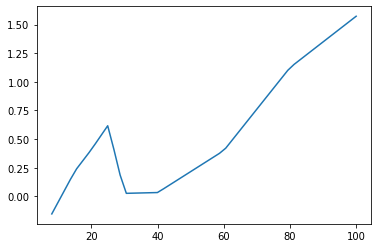

In [50]:
plt.plot(np.linspace(8, 100), [f(m) for m in np.linspace(8, 100)])

In [51]:
MoverH = allowed_MoverH[study]
Z = [0.014 * 10**M_H for M_H in MoverH]

In [52]:
y_c = [vice.yields.ccsne.fractional("c", MoverH=M_H, rotation=0, study=study)[0] for M_H in MoverH]

In [53]:
vice.yields.ccsne.settings["C"] = vice.toolkit.interpolation.interp_scheme_1d(Z, y_c)

In [54]:
vice.yields.ccsne.settings["C"] = vice.toolkit.interpolation.interp_scheme_1d(Z, yields_c)

In [55]:
vice.yields.ccsne.settings["au"] = vice.toolkit.interpolation.interp_scheme_1d(Z, yields_c12)
vice.yields.ccsne.settings["ag"] = vice.toolkit.interpolation.interp_scheme_1d(Z, yields_c13)

In [56]:
vice.yields.ccsne.fractional("c")

[0.001548777200030053, 1.6156077284818306e-06]

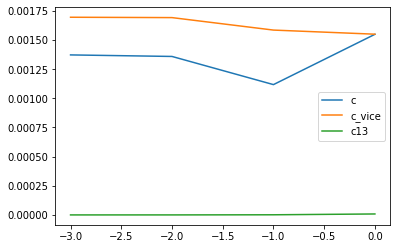

In [57]:
plt.plot(MoverH, yields_c, label="c")
plt.plot(MoverH, y_c, label="c_vice")
plt.plot(MoverH, yields_c13, label="c13")
plt.legend()

# Equilibrium Tracks

In [59]:
import c_isotopic_yields

In [60]:
out = vice.output("output/cristallo11")
def get_value(name, i=-1):
    return np.array([out.zones["zone%i" % (int(10*j))].history[name][i] for j in R])

In [61]:
R = np.arange(3, 11, 0.1)

Z = get_value("z")
eta = get_value("eta_0")
r = get_value("r_eff")
sfr = get_value("sfr")
Mg = get_value("mgas")
dt = 0.1
Mg_dot = (Mg - get_value("mgas", i=-11))/dt
Mstar = get_value("mstar")
tau_sfh = - Mg/Mg_dot
tau_star = Mg/(sfr * 10**9)
t = out.zones["zone0"].history["time"]
dt = 0.01

MoverH = np.log10(Z/0.014)

In [62]:
def calc_equlibrium(y_agb_a, pii=1, y_o_cc = 0.015):
    denom = pii*(1 + eta - r - tau_star/tau_sfh)
    
    o_eq = pii*y_o_cc/denom

    c_eq = (y_agb_a + fit_model(y_agb_a, pii)(Z))/denom
    # c_eq = (y_agb_a + y_c_cc)/denom
    o_h = aah.abundance_to_bracket(o_eq, "O")
    c_h = aah.abundance_to_bracket(c_eq, "C")
    c_o = c_h - o_h
    return o_h, c_o

In [63]:
Zs = 0.014*10**MoverH
y_agb_c12 = y_agb("au")
y_agb_c13 = y_agb("ag")
y_cc_c12 = [vice.yields.ccsne.settings["au"](Z) for Z in Zs]
y_cc_c13 = [vice.yields.ccsne.settings["ag"](Z) for Z in Zs]

In [64]:
import apogee_analysis as aah

In [73]:
pii = 1
#r = 0.4
y_o_cc = 0.015
#eta = np.linspace(0.5, 2.5, 100)
denom = pii*(1 + eta - r)

o_eq = pii*y_o_cc/denom

c12_eq = (y_agb_c12 + y_cc_c12)/denom
c13_eq = (y_agb_c13 + y_cc_c13)/denom

# c_eq = (y_agb_a + y_c_cc)/denom
o_h = aah.abundance_to_bracket(o_eq, "O")
c12_h = np.log10(c12_eq/vice.solar_z("c"))
c13_h = np.log10(c13_eq/vice.solar_z("c")*80)
c_o = c12_h - o_h


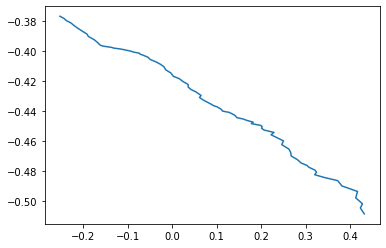

In [74]:
plt.plot(o_h, c_o)

(0.0, 249.23315104107706)

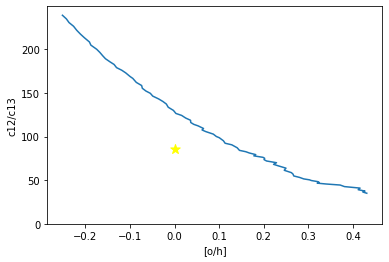

In [75]:
plt.plot(o_h, c12_eq/c13_eq)
plt.xlabel("[o/h]")
plt.ylabel("c12/c13")
plt.scatter(0, 86, s=100, marker="*", color="yellow")
plt.ylim(0)

Text(0.5, 0, 'MoverH')

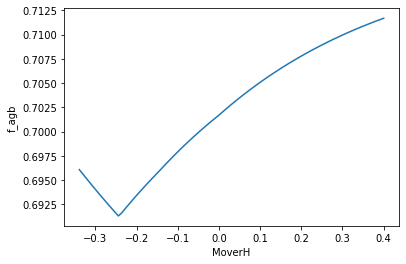

In [78]:

plt.plot(MoverH, y_agb_c13/(y_cc_c13 + y_agb_c13))
plt.ylabel("f_agb")
plt.xlabel("MoverH")

In [79]:
obs = pd.read_csv("yan_19.txt", sep="\s+", skiprows=1)

<ErrorbarContainer object of 3 artists>

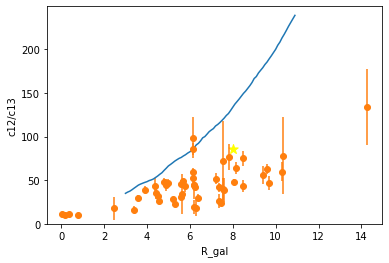

In [80]:
plt.plot(R, c12_eq/c13_eq)
plt.xlabel("R_gal")
plt.ylabel("c12/c13")
plt.scatter(8, 86, s=100, marker="*", color="yellow")
plt.ylim(0)
plt.errorbar(obs["R_gal"], obs["C12_C13"], yerr=obs["Error"], fmt="o")

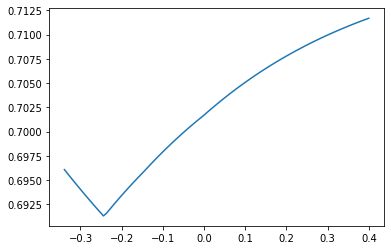

In [81]:
plt.plot(MoverH, y_agb_c13/(y_agb_c13 + y_cc_c13))